## Corona Cases Forecasting for Germany on a County Level
### Visualize data based on county:

In [1]:
import pandas as pd 
import geopandas as gpd
import descartes # to plot
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# autoreload packages
%load_ext autoreload
%autoreload 2
import utils.plotting as plotting
import utils.preprocessing as prep

#### Get Corona data:
RKI_Corona_Landkreise.csv:

GEN                   | NUTS  | cases | deaths | county
--------------------- | ----- | ----- | ------ | ----------
Flensburg             | DEF06 | 21    | 0      |  SK Flensburg <br>
Herzogtum Lauenburg   | DEF07 | 15    | 0      |  LK Herzogtum Lauenburg


df_time: 

Landkreis                 | AnzahlFall | AnzahlTodesfall | Meldedatum               | IdLandkreis | NUTS3  | Bevoelkerung
------------------------- | ---------- | --------------- | ------------------------ | ----------- | ------ | ------------
SK Magdeburg              | 2          | 0               | 2020-03-18T00:00:00.000Z | 15003       | NaN    | NaN
SK Magdeburg              | 1          | 0               | 2020-03-12T00:00:00.000Z | 15003       | NaN    | NaN
LK Altmarkkreis Salzwedel | 1          | 0               | 2020-03-12T00:00:00.000Z | 15081       | NaN    | NaN

In [4]:
#data = pd.read_csv("data/RKI_Corona_Landkreise.csv") 
df_time = pd.read_csv("data/df_time.csv") 
df_time.head(2)
#data.describe()

IdBundesland      Bundesland     Landkreis Altersgruppe Geschlecht  \
0            15  Sachsen-Anhalt  SK Magdeburg      A35-A59          M   
1            15  Sachsen-Anhalt  SK Magdeburg      A35-A59          W   

   AnzahlFall  AnzahlTodesfall  ObjectId                Meldedatum  \
0           2                0    154936  2020-03-18T00:00:00.000Z   
1           1                0    154937  2020-03-12T00:00:00.000Z   

   IdLandkreis NUTS3 Flaeche Bevoelkerung maennlich weiblich Dichte  
0        15003   NaN     NaN          NaN       NaN      NaN    NaN  
1        15003   NaN     NaN          NaN       NaN      NaN    NaN

##### Get additional information about the Counties:
e.g. population density, public transport information, gender distribution, age distribution

### Load county shape information

https://public.opendatasoft.com/explore/dataset/landkreise-in-germany/export/

most important: cca_2 (= county identifier) and geometry:

name_2                   | cca_2  | geometry
------------------------ | ------ | -------------------------------------------------
Freiburg im Breisgau     | 08311  | POLYGON ((7.790447235107478 47.96881103515624,...
Dillingen an der Donau   | 09773  | POLYGON ((10.6144847869873 48.75083541870145, ...


In [2]:
county_df = gpd.read_file('data/landkreise-in-germany.shp', encoding='utf-8', dtype={'cca_2': str})
# convert cca_2 to float for merge later
county_df = county_df.astype({'cca_2': 'float64'})
county_df.head(2)

id_0  iso   name_0  id_1             name_1  id_2                  name_2  \
0  86.0  DEU  Germany   1.0  Baden-Württemberg  12.0    Freiburg im Breisgau   
1  86.0  DEU  Germany   2.0             Bayern  68.0  Dillingen an der Donau   

     hasc_2  ccn_2   cca_2      type_2 engtype_2 nl_name_2 varname_2  \
0  DE.BW.FB    0.0  8311.0  Stadtkreis  District      None      None   
1  DE.BY.DD    0.0  9773.0   Landkreis  District      None      None   

                                            geometry  
0  POLYGON ((7.790447235107478 47.96881103515624,...  
1  POLYGON ((10.6144847869873 48.75083541870145, ...

### Aggregate Information for different dates

In [5]:
# aggregate number of cases by until any date
df_time  = df_time.astype({'IdLandkreis': 'float64'})
df_agg = df_time.sort_values(['IdLandkreis','Meldedatum'],ascending=False)\
    .groupby(['IdLandkreis','Meldedatum'])\
    .agg({'AnzahlFall':sum})\
    .groupby('IdLandkreis').cumsum().reset_index()

In [8]:
df_date = prep.cases_at_date(df_agg)
df_date

IdLandkreis  AnzahlFall
0         1001.0          12
1         1002.0          36
2         1003.0          21
3         1004.0           1
4         1051.0          12
5         1053.0          21
6         1054.0          15
7         1055.0          11
8         1056.0          62
9         1057.0          24
10        1058.0          60
11        1059.0          48
12        1060.0          54
13        1061.0          24
14        1062.0          24
15        2000.0        1174
16        3101.0          24
17        3102.0          16
18        3103.0          18
19        3151.0          54
20        3153.0          36
21        3154.0          22
22        3155.0          24
23        3157.0          26
24        3158.0           6
25        3159.0          84
26        3241.0         226
27        3251.0          88
28        3252.0          36
29        3254.0          66
..           ...         ...
375      15084.0          14
376      15085.0          12
377      15086.0           3
378      15087.0           5
379      15088.0          12
380      15089.0          13
381      15090.0           7
382      15091.0           8
383      16051.0          27
384      16052.0           4
385      16053.0          13
386      16054.0           2
387      16055.0          10
388      16056.0           1
389      16061.0           7
390      16062.0           3
391      16063.0           4
392      16064.0           5
393      16065.0          11
394      16066.0          13
395      16067.0           4
396      16068.0           2
397      16069.0           1
398      16070.0           5
399      16071.0           9
400      16073.0          12
401      16074.0          13
402      16075.0           7
403      16076.0          30
404      16077.0           4

[405 rows x 2 columns]

#### Merge Geometric and Corona Information

In [9]:
df = pd.merge(left=county_df , right= df_date, how='left', left_on='cca_2', right_on='IdLandkreis')
df.head(3)

id_0  iso   name_0  id_1             name_1   id_2                  name_2  \
0  86.0  DEU  Germany   1.0  Baden-Württemberg   12.0    Freiburg im Breisgau   
1  86.0  DEU  Germany   2.0             Bayern   68.0  Dillingen an der Donau   
2  86.0  DEU  Germany   2.0             Bayern  107.0                Nürnberg   

     hasc_2  ccn_2   cca_2            type_2 engtype_2 nl_name_2 varname_2  \
0  DE.BW.FB    0.0  8311.0        Stadtkreis  District      None      None   
1  DE.BY.DD    0.0  9773.0         Landkreis  District      None      None   
2  DE.BY.NR    0.0  9564.0  Kreisfreie Stadt  District      None      None   

                                            geometry  IdLandkreis  AnzahlFall  
0  POLYGON ((7.790447235107478 47.96881103515624,...       8311.0       150.0  
1  POLYGON ((10.6144847869873 48.75083541870145, ...       9773.0         6.0  
2  (POLYGON ((11.18831062316894 49.38963317871099...       9564.0        67.0

C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


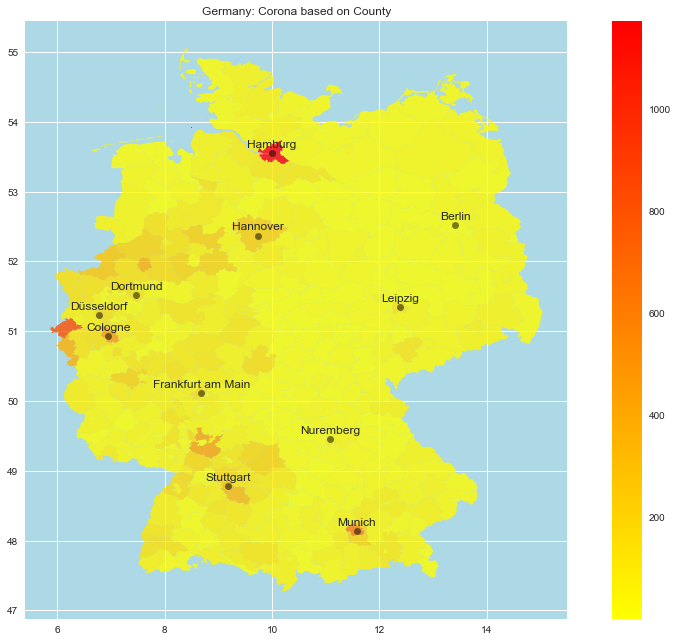

In [11]:
plotting.plot_map(df, "AnzahlFall")

C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-package

C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\henri\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in l

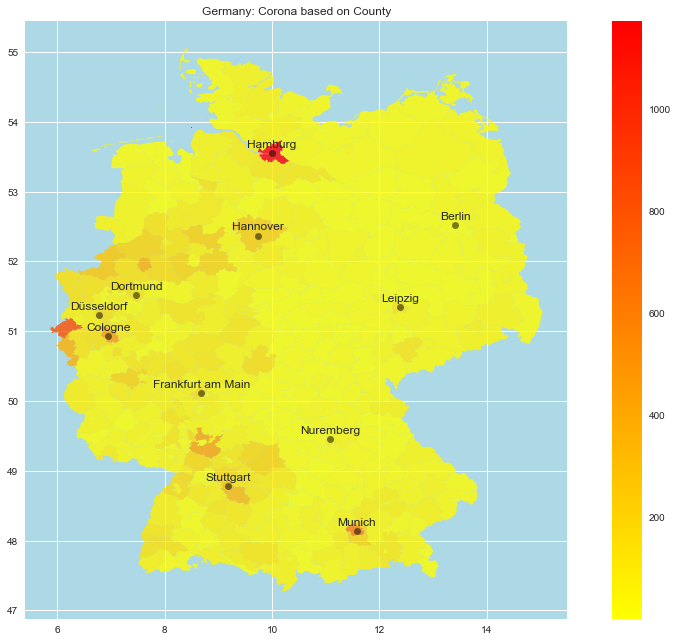

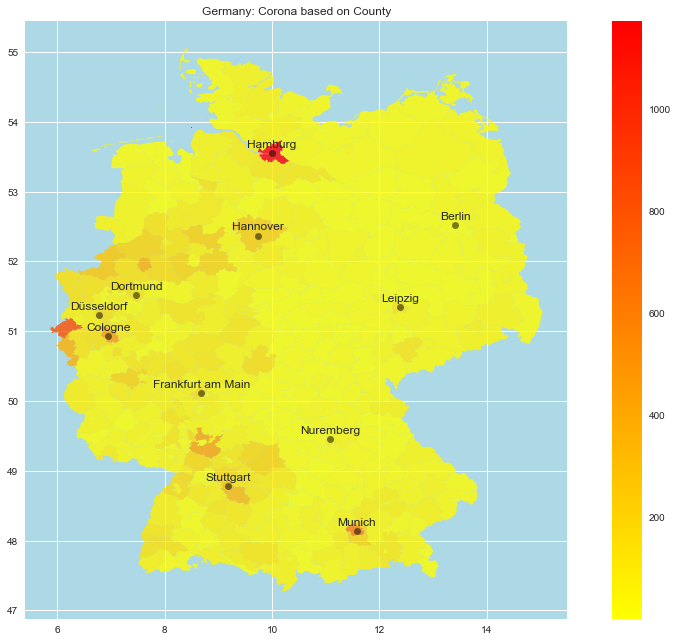

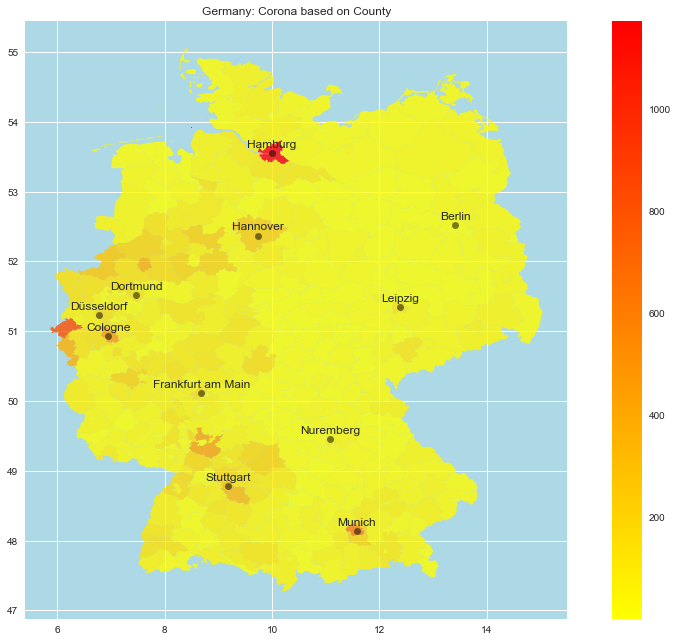

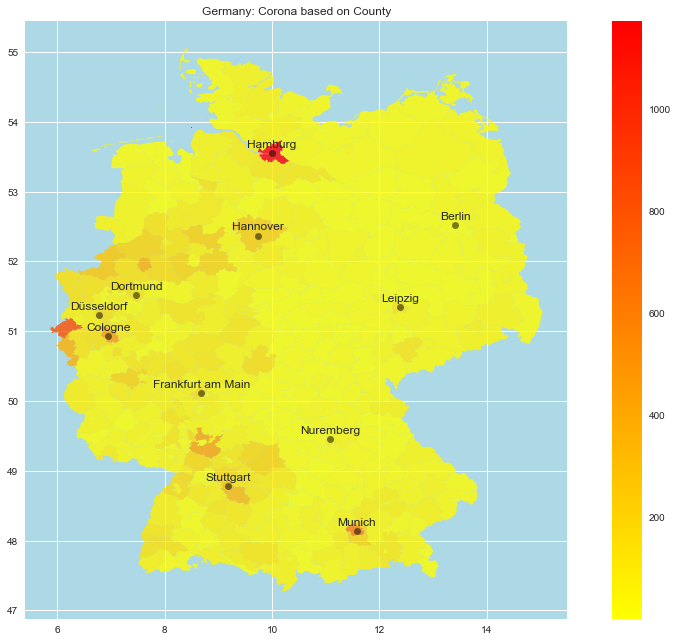

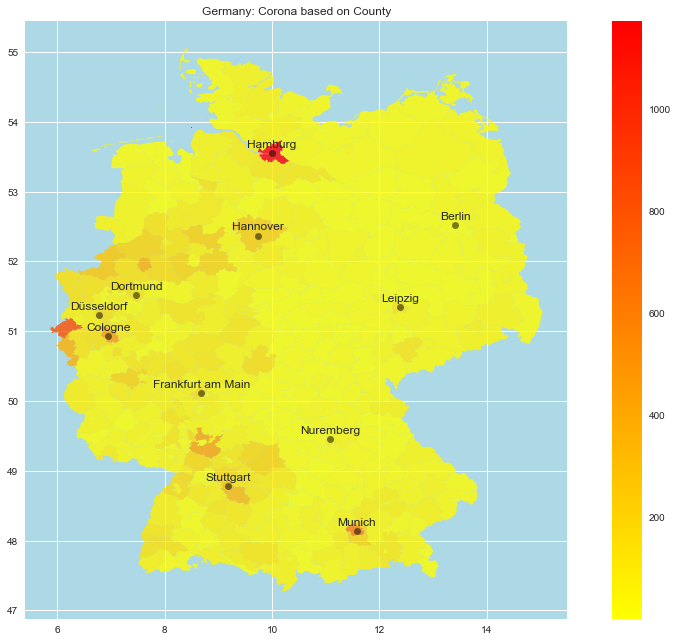

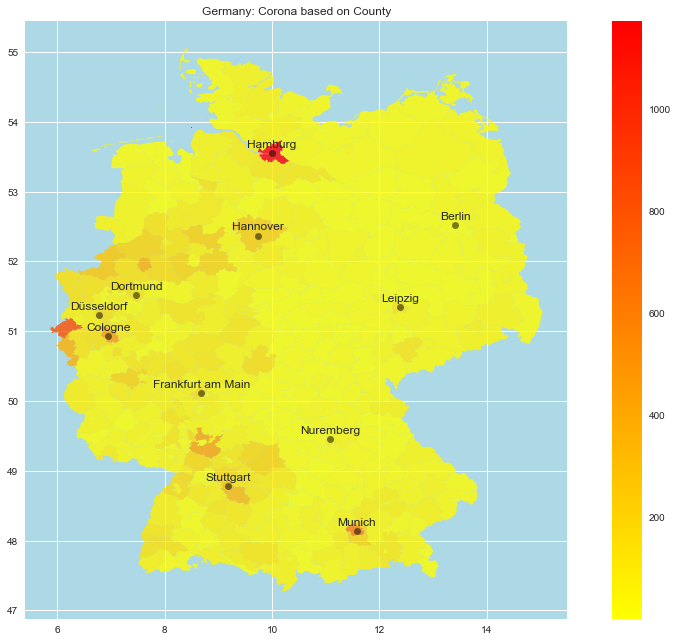

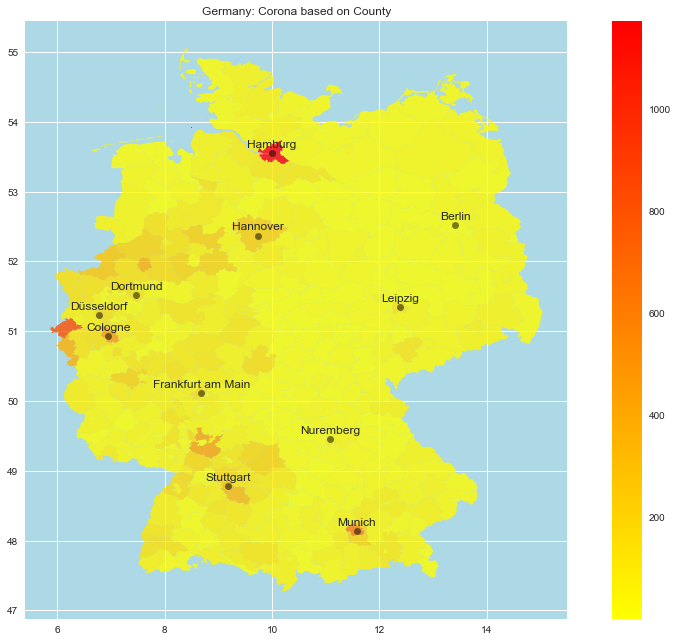

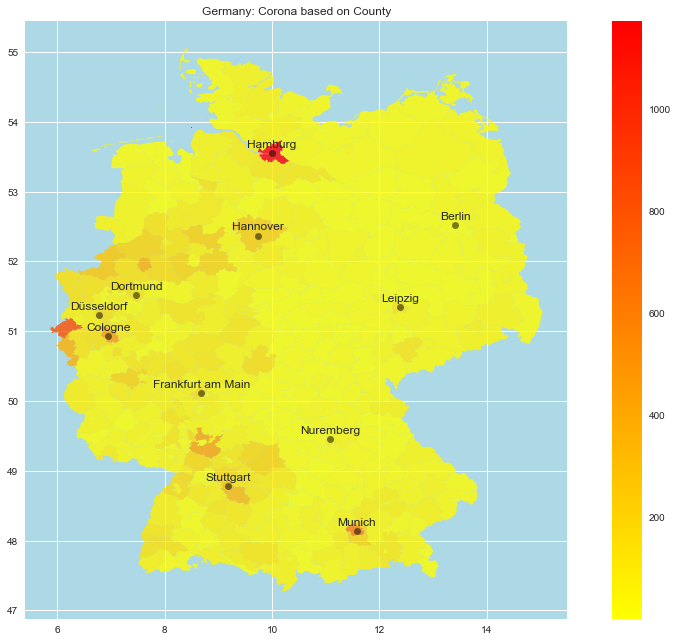

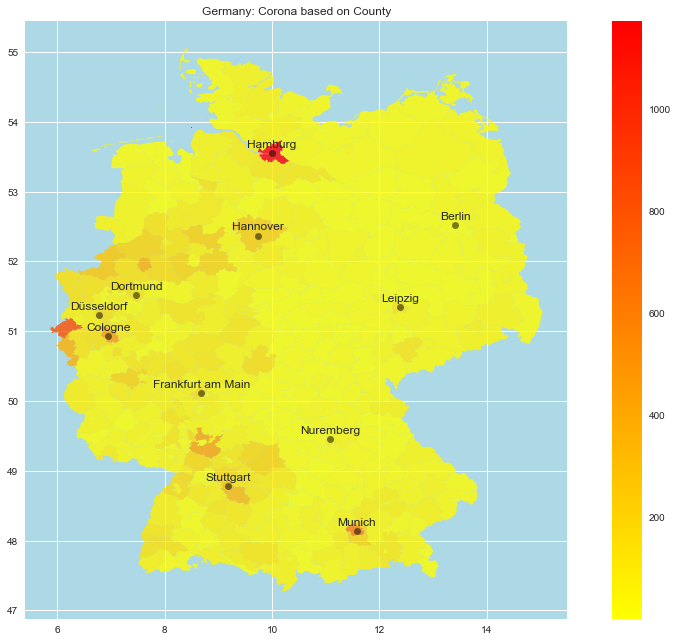

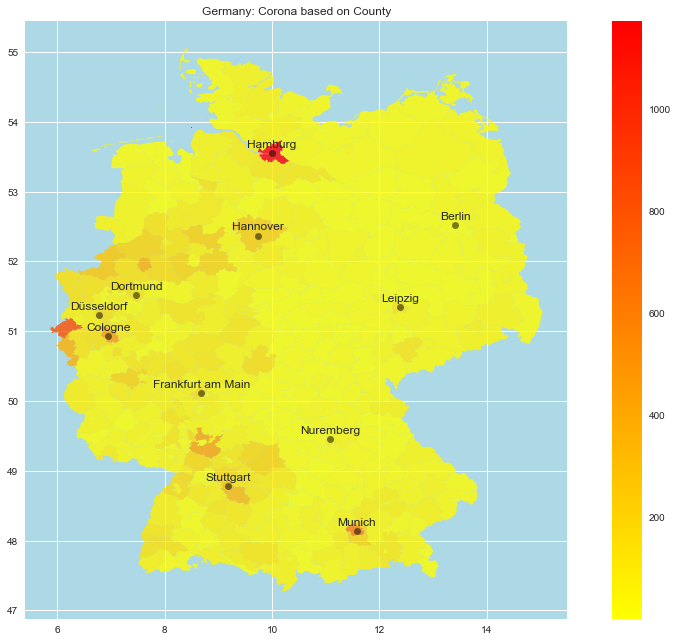

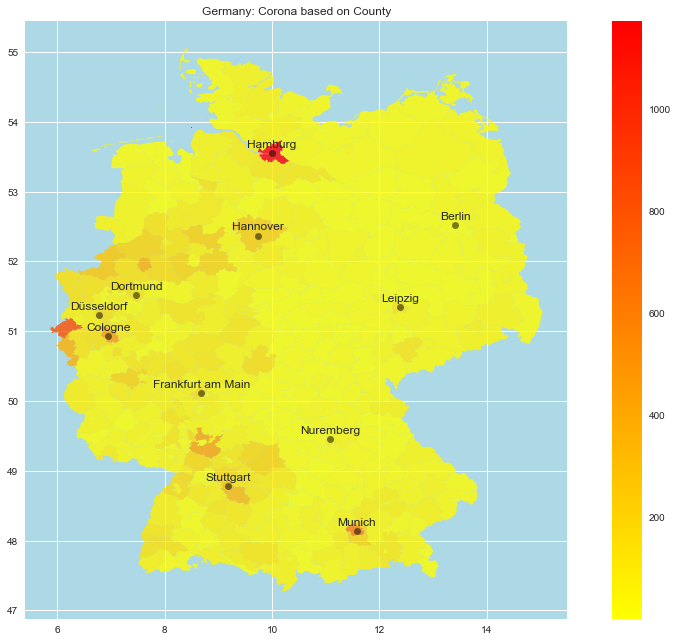

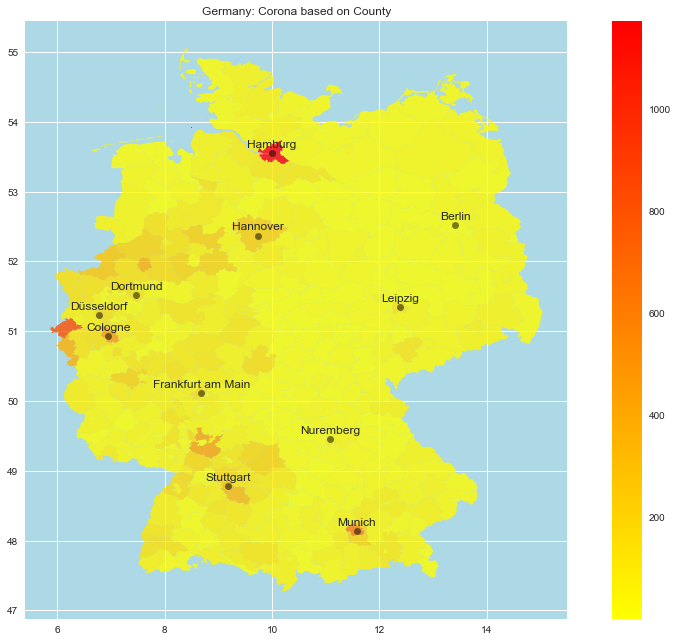

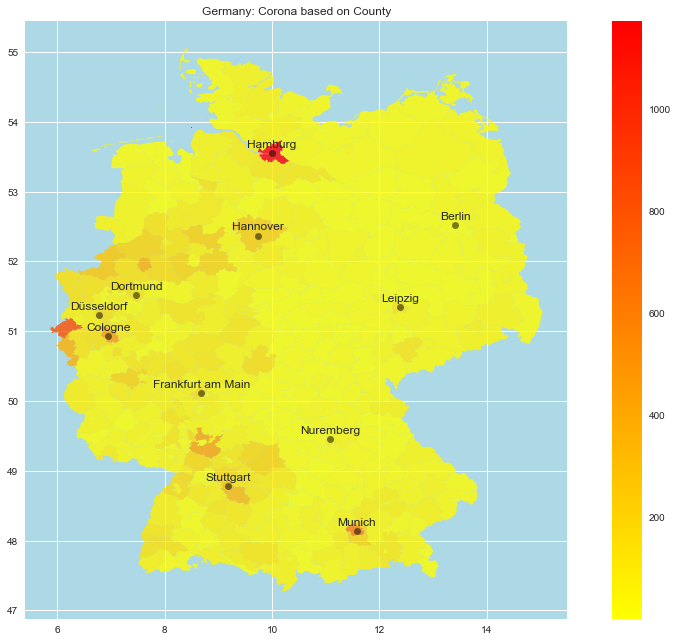

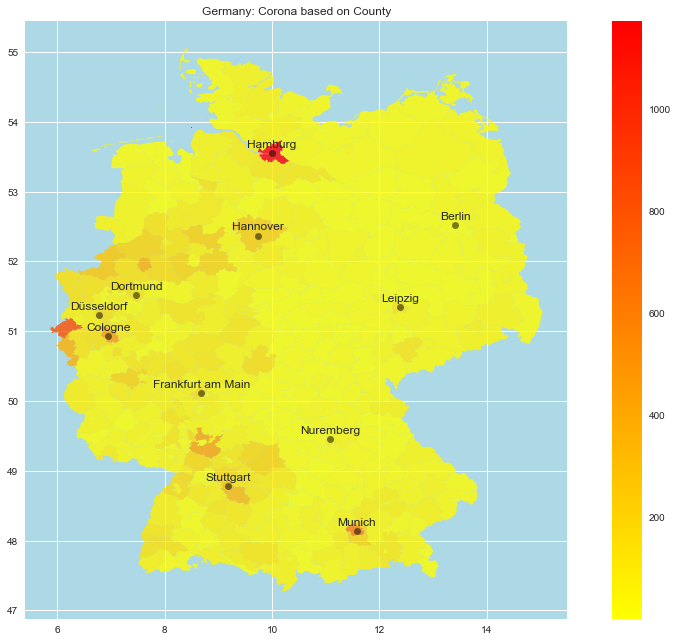

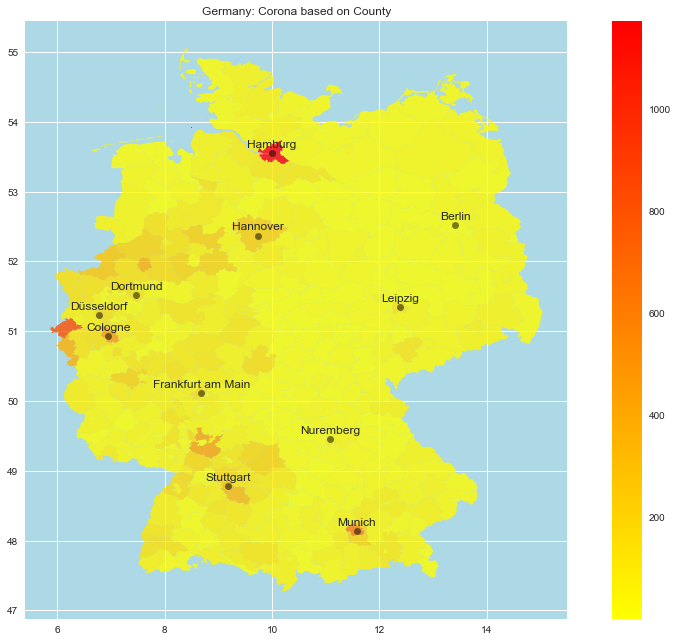

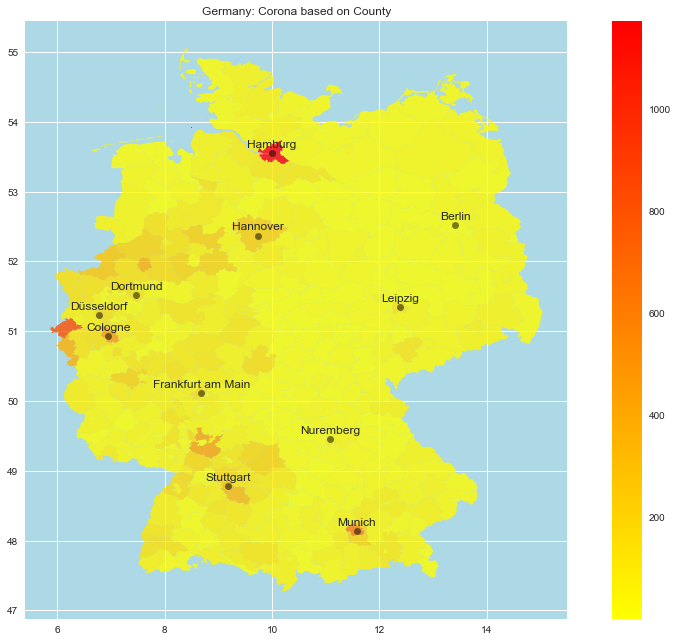

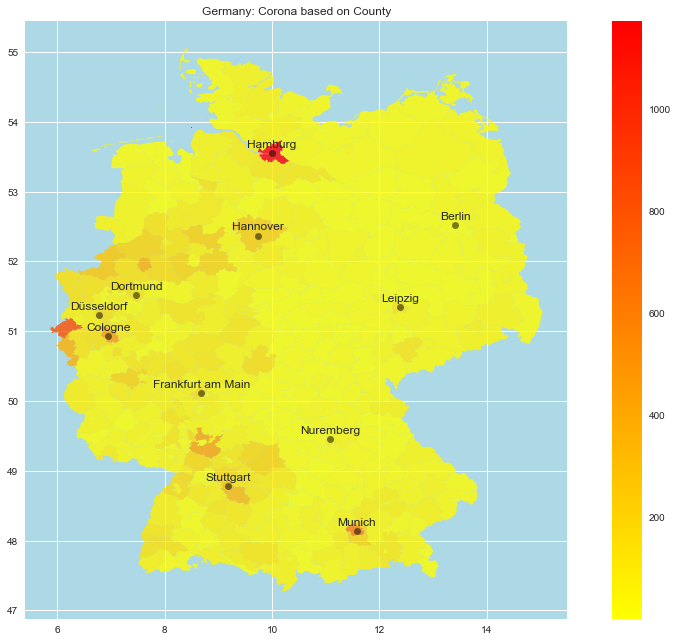

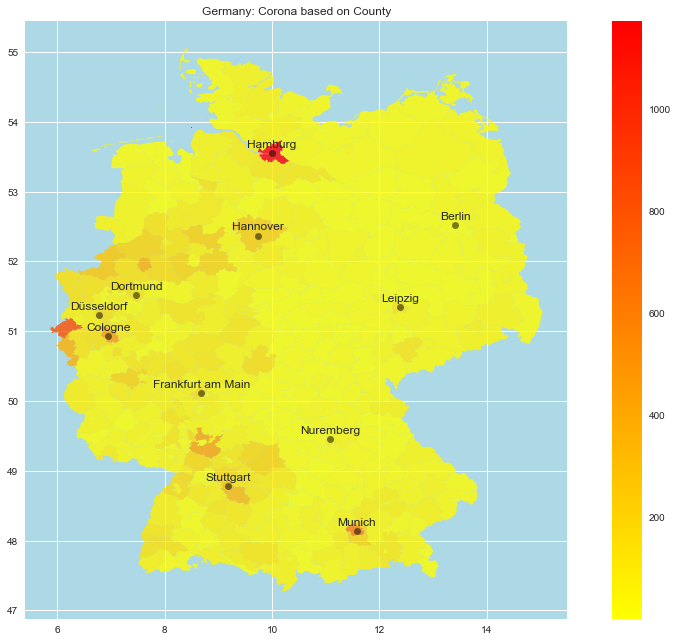

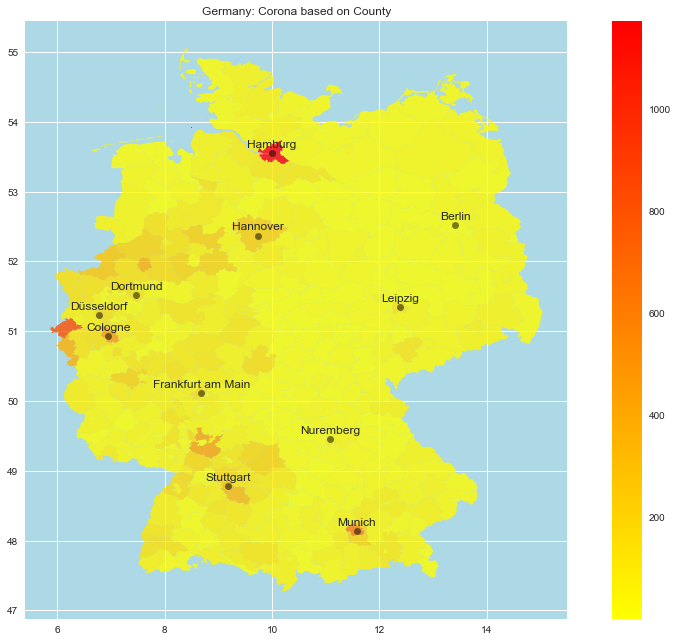

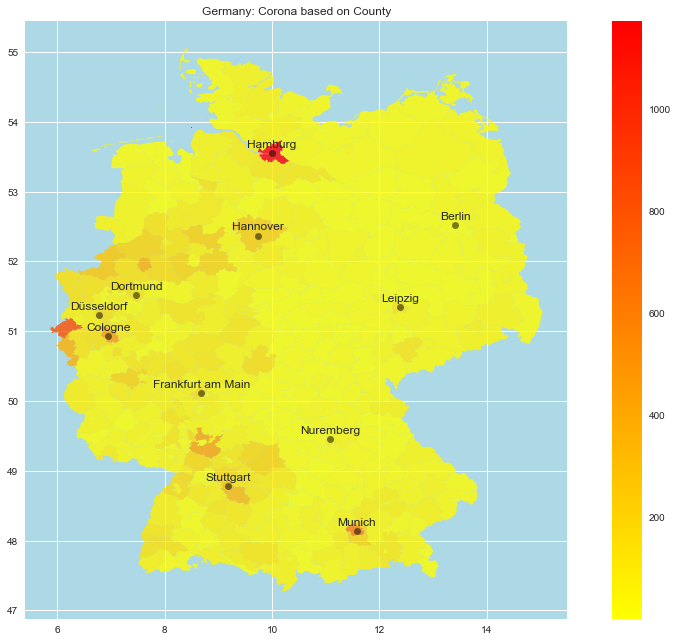

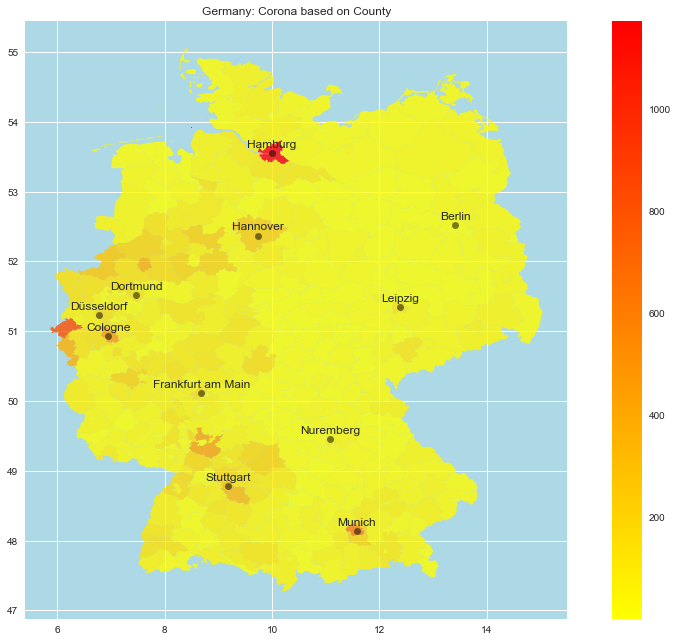

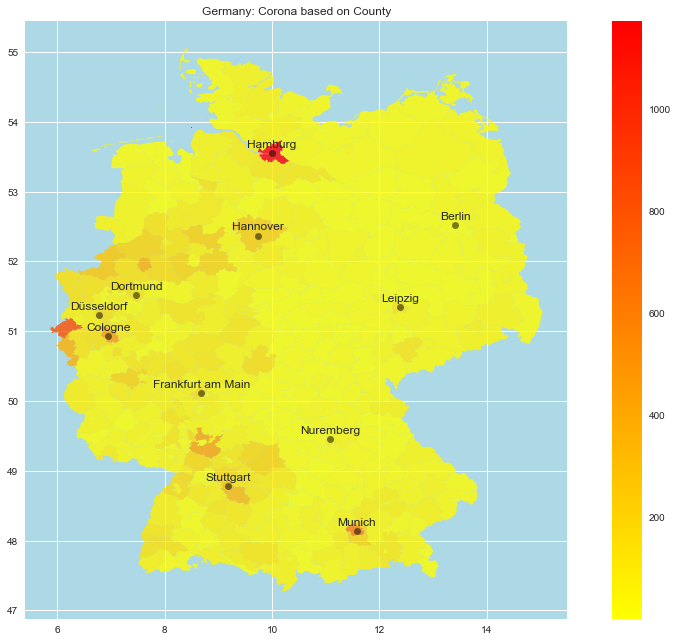

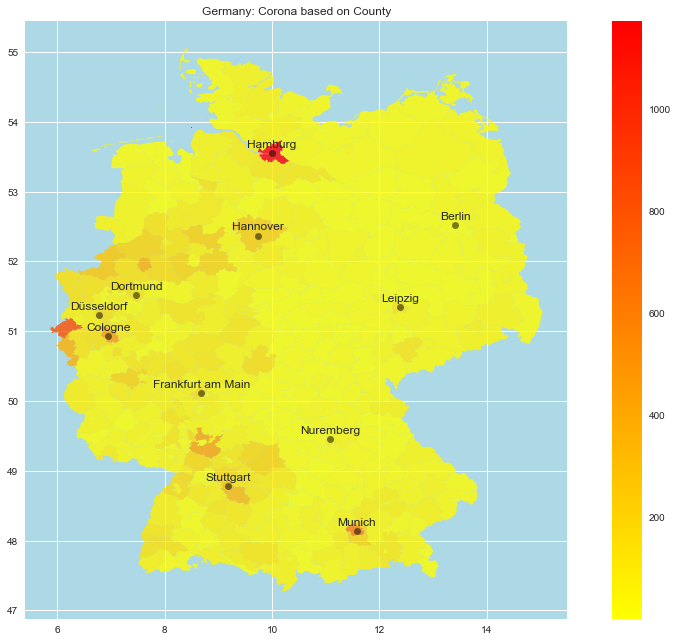

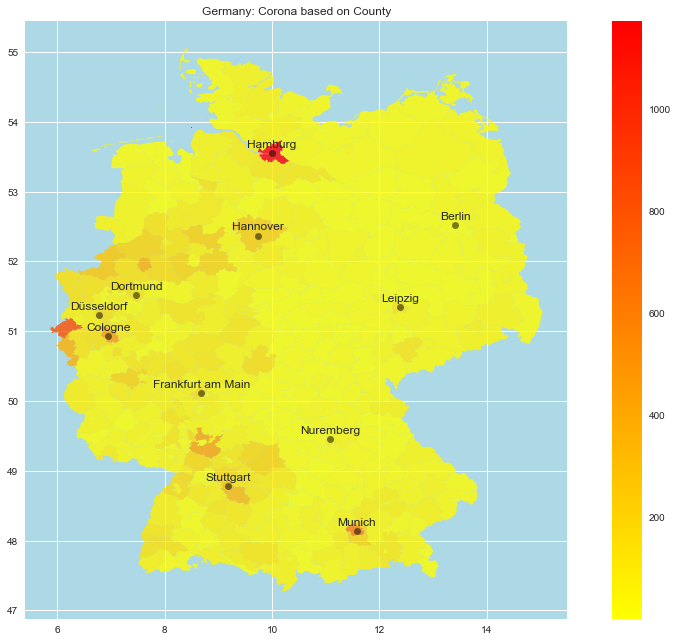

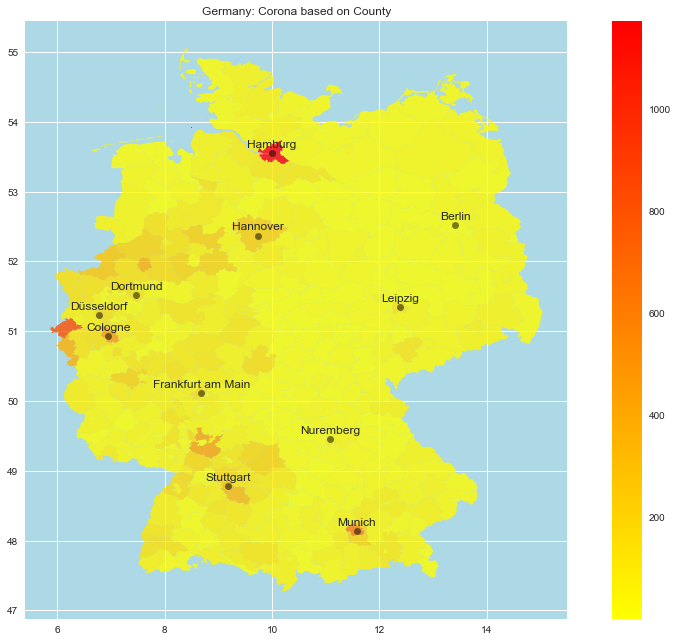

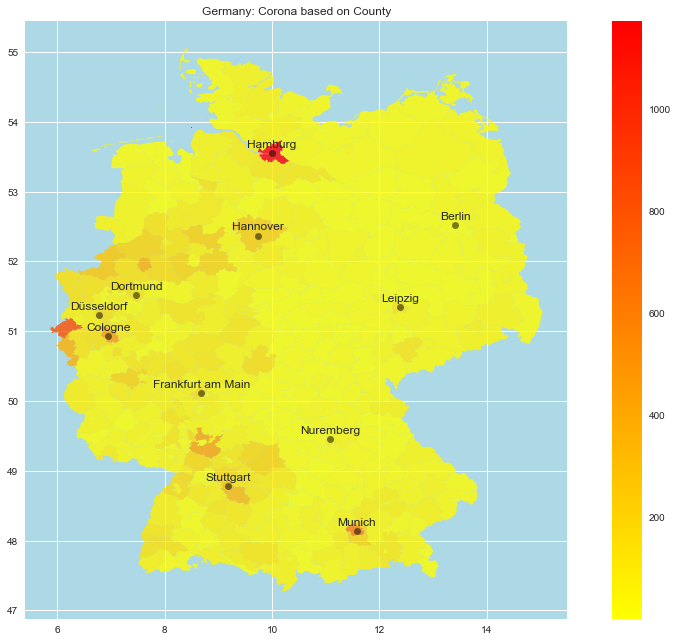

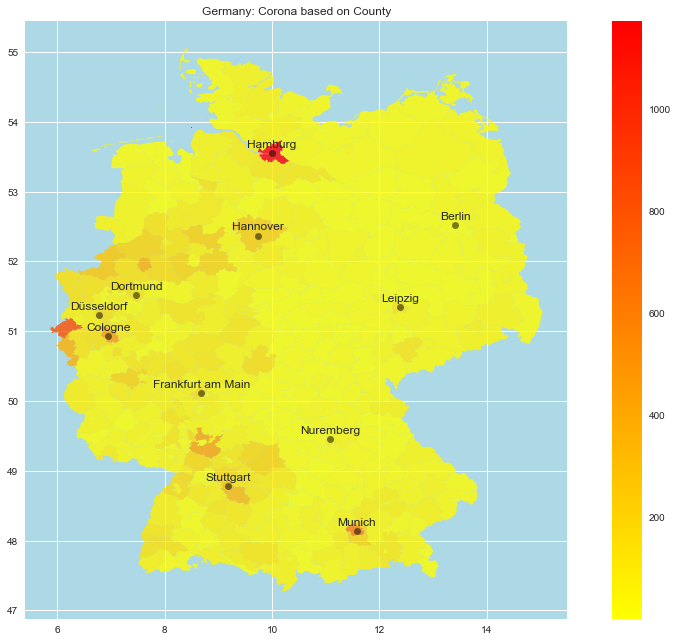

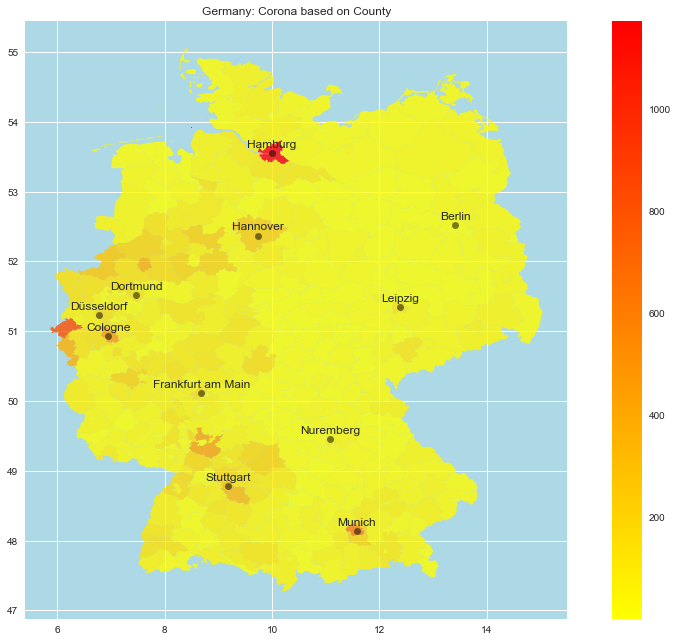

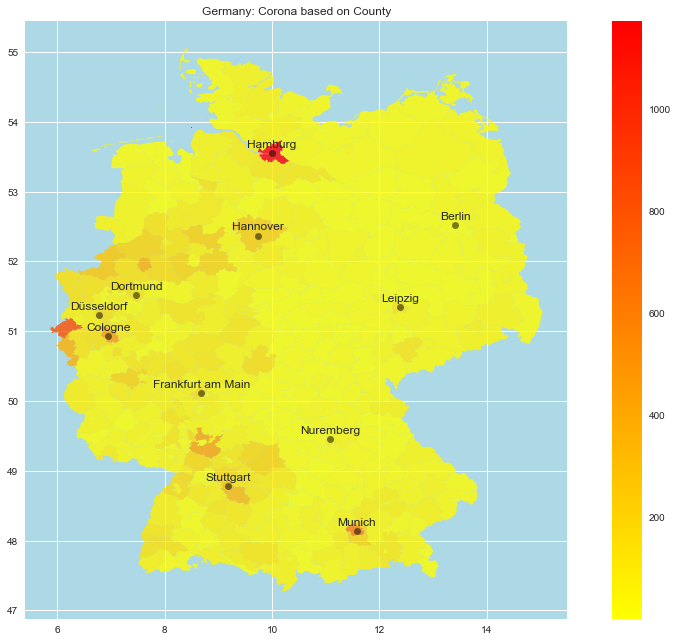

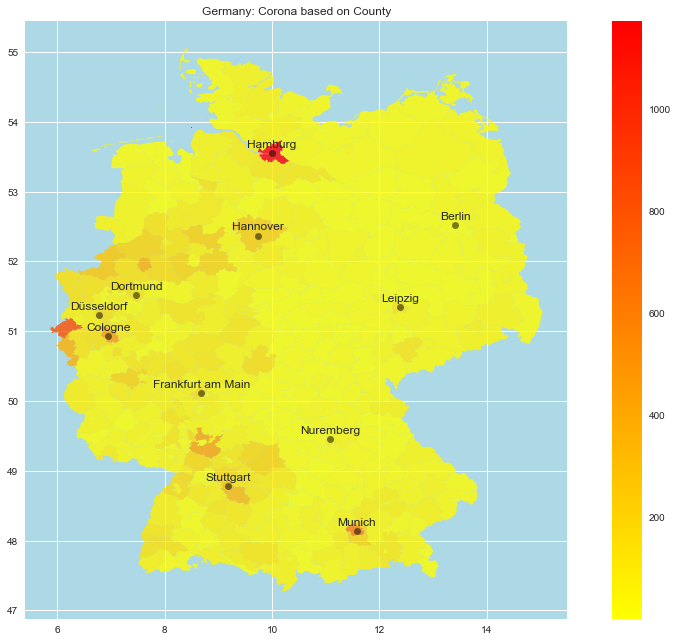

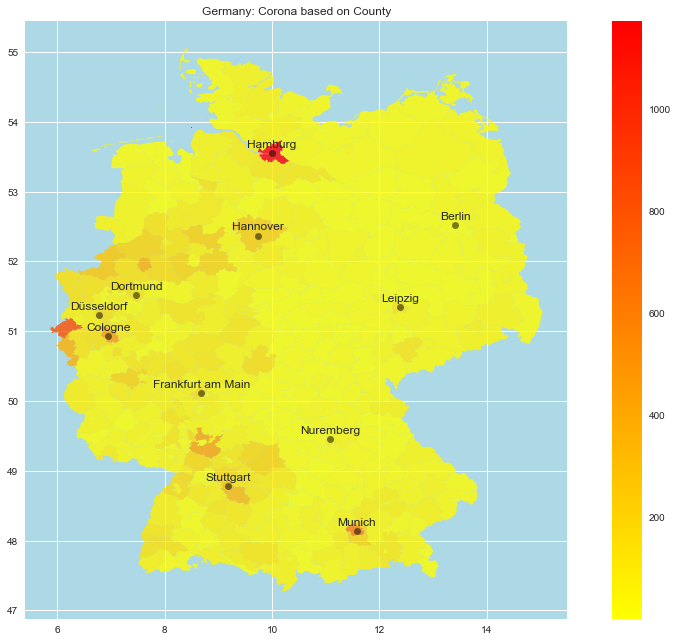

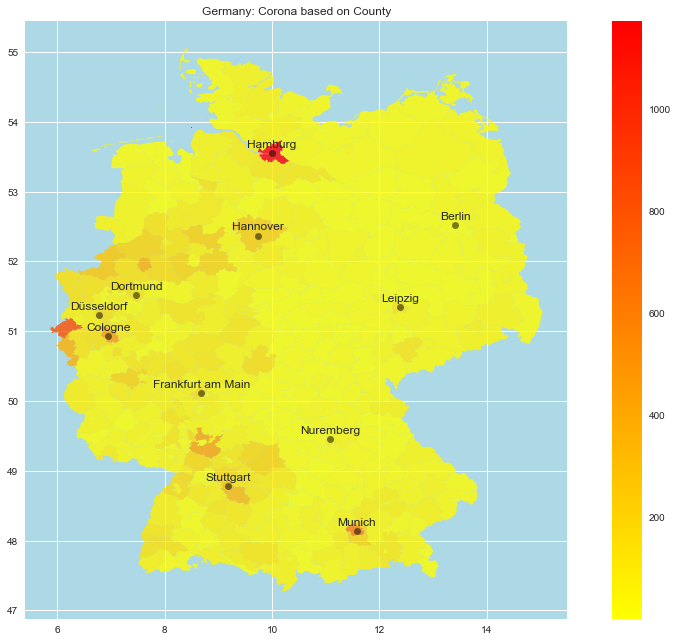

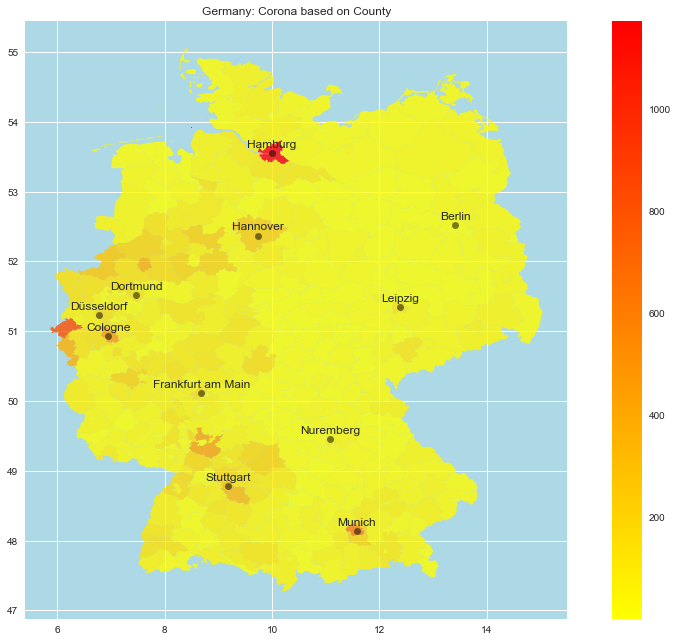

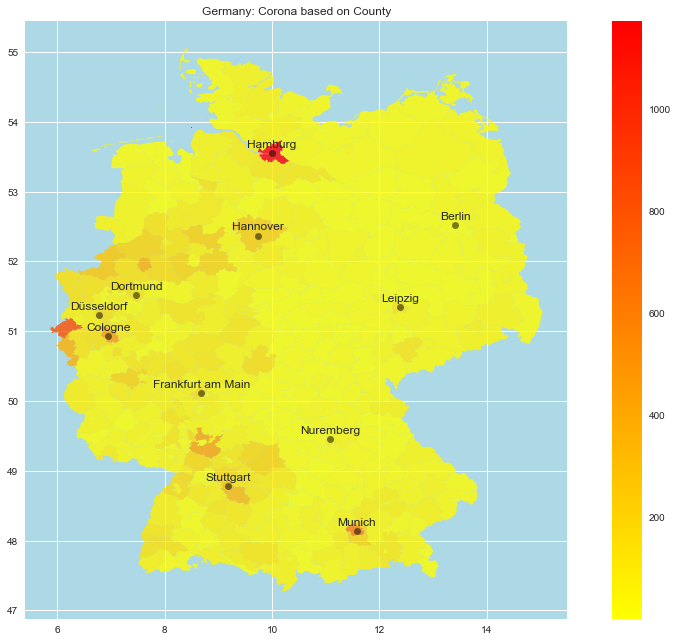

In [52]:
# plot for all dates:
import time
date_1   = df_time['Meldedatum'].min()
date_cur = df_time['Meldedatum'].max()

dates = df_time['Meldedatum'].sort_values().astype({'Meldedatum': 'str'}).unique()

for date in dates:
    df_date = prep.cases_at_date(df_agg)
    df = pd.merge(left=county_df , right= df_date, how='left', left_on='cca_2', right_on='IdLandkreis')
    plotting.plot_map(df, "AnzahlFall")
    time.sleep(2)